# DMD analysis 

In [1]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from stl import mesh
from flowtorch.data import FOAMDataloader, mask_box
from flowtorch.analysis import DMD

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

output = "./output/"
!mkdir -p output

In [2]:
Ma = 0.75
U_inf = 255.22
a_inf = U_inf / Ma
rho_inf = 1.19058
chord = 0.6010500

In [3]:
def add_naca0012_patch(axis, scale=1.0):
    x_up = naca_stl.x[naca_stl.y > 0] * scale
    y_up = naca_stl.y[naca_stl.y > 0] * scale
    x_low = naca_stl.x[naca_stl.y < 0] * scale
    y_low = naca_stl.y[naca_stl.y < 0] * scale
    axis.fill_between(x_up, 0.0, y_up, color="k")
    axis.fill_between(x_low, y_low, 0.0, color="k")
    
naca_stl = mesh.Mesh.from_file("../geometry/naca0012.stl")

In [4]:
def normalize_frequency(f):
    return 2*np.pi*chord*f/U_inf

In [5]:
x2D = pt.load(f'{output}x_masked_2D_ref2.pt')
y2D = pt.load(f'{output}y_masked_2D_ref2.pt')
x3D = pt.load(f'{output}x_masked_3D_ref0.pt')
y3D = pt.load(f'{output}y_masked_3D_ref0.pt')
vol2D = pt.load(f'{output}vol_masked_2D_ref2.pt')
vol3D = pt.load(f'{output}vol_masked_3D_ref0.pt')
t2D = pt.load(f'{output}t_2D_ref2.pt')
t3D = pt.load(f'{output}t_3D_ref0.pt')
dm2D = pt.load(f'{output}comp_data_matrix_2D_ref2.pt')
dm3D = pt.load(f'{output}comp_data_matrix_3D_ref0.pt')

In [6]:
t2Dw = t2D[309:2310]
t3Dw = t3D[322:1012]

In [7]:
np2D = x2D.shape[0]
np3D = x3D.shape[0]

## DMD anylsis

In [8]:
it = int(t2D.shape[0]*6.0/9.0)
dmd2D = DMD(dm2D[:, :it], dt=t2Dw[1]-t2Dw[0], rank=100)

In [9]:
dmd3D = DMD(dm3D, dt=t3Dw[1]-t3Dw[0], rank=50)

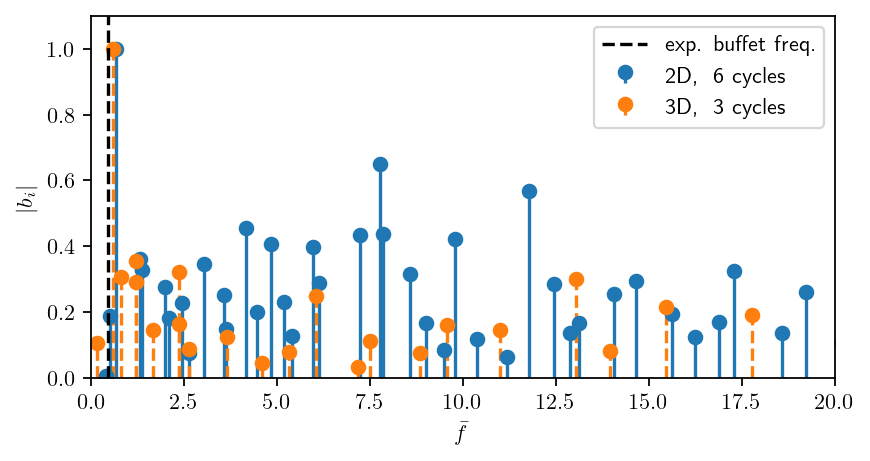

In [12]:
amplitude2D = dmd2D.amplitude.abs() * dmd2D.eigvals.abs()
freq2D = dmd2D.frequency
freq2D_i_pos = (freq2D > 10).nonzero().flatten()
amplitude2D /= amplitude2D[freq2D_i_pos].max()
amplitude3D = dmd3D.amplitude.abs() * dmd3D.eigvals.abs()
freq3D = dmd3D.frequency
freq3D_i_pos = (freq3D > 10).nonzero().flatten()
amplitude3D /= amplitude3D[freq3D_i_pos].max()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.stem(normalize_frequency(freq2D[freq2D_i_pos].numpy()), amplitude2D[freq2D_i_pos].numpy(), basefmt="none", label="2D, ~6 cycles")
ax.stem(normalize_frequency(freq3D[freq3D_i_pos].numpy()), amplitude3D[freq3D_i_pos].numpy(), basefmt="none", linefmt="C1--", markerfmt="C1o", label="3D, ~3 cycles")
ax.set_xlabel(r"$\bar{f}$")
ax.set_ylabel(r"$|b_i|$")
#ax.set_xscale("log")
ax.set_xlim(0, 20)
ax.set_ylim(0, 1.1)
ax.axvline(0.47, ls="--", c="k", label="exp. buffet freq.")
#ax.text(27, 1.0, "exp. buffet freq.", rotation=90)
ax.legend()
plt.savefig(output + "dmd_freq_2D_3D.svg", bbox_inches="tight")
plt.savefig(output + "dmd_freq_2D_3D.pdf", bbox_inches="tight")

In [13]:
_, top_pos = amplitude2D[freq2D_i_pos].topk(49)
top_i = freq2D_i_pos[top_pos]

growth = dmd2D.growth_rate
for i in top_i[:20]:
    print(i.item(), freq2D[i].item(), (freq2D[i]/freq2D[top_i[0]]).item(), growth[i].item())

88 45.161285400390625 1.0 -1.5958805084228516
56 526.0389404296875 11.648006439208984 -110.43577575683594
40 795.7882080078125 17.62102699279785 -173.82952880859375
72 281.49578857421875 6.233121871948242 -89.96219635009766
54 531.2315673828125 11.762986183166504 -107.40276336669922
58 488.9831848144531 10.827486038208008 -153.9266357421875
46 661.1964111328125 14.640779495239258 -153.46234130859375
66 327.8900146484375 7.260422706604004 -126.64239501953125
62 404.0115051269531 8.945969581604004 -174.07334899902344
86 88.7960433959961 1.9661983251571655 -5.3593339920043945
78 205.0142822265625 4.539602279663086 -84.57294464111328
90 92.16387939453125 2.040771722793579 -99.78282165527344
22 1168.5904541015625 25.875934600830078 -123.8155288696289
52 579.5972900390625 12.833941459655762 -134.01747131347656
30 989.6724853515625 21.9141788482666 -116.71601104736328
60 413.8806457519531 9.164501190185547 -71.9051284790039
38 840.7083129882812 18.615686416625977 -115.8946304321289
92 134.668

In [14]:
_, top_pos = amplitude3D[freq3D_i_pos].topk(24)
growth_norm = -pt.log(dmd3D.eigvals.abs()) / pt.log(dmd3D.eigvals).abs()
growth = dmd3D.growth_rate
top_i = freq3D_i_pos[top_pos]
for i in top_i[:24]:
    print(i.item(), freq3D[i].item(), (freq3D[i]/freq3D[top_i[0]]).item(), growth[i].item(), growth_norm[i].item())

46 39.5601692199707 1.0 -27.780332565307617 0.11107170581817627
41 81.0921630859375 2.0498437881469727 -28.93937110900879 0.05670620873570442
32 159.34300231933594 4.027864456176758 -237.5628204345703 0.23087237775325775
43 55.036521911621094 1.3912104368209839 -39.46217727661133 0.1133815199136734
10 882.013916015625 22.295503616333008 -63.60249328613281 0.011476047337055206
39 82.76224517822266 2.092059850692749 -361.2503356933594 0.5705363750457764
22 408.9042663574219 10.336261749267578 -212.7784881591797 0.0825357511639595
6 1044.401123046875 26.400320053100586 -133.924560546875 0.02040436491370201
4 1200.2408447265625 30.339628219604492 -90.54218292236328 0.01200526300817728
34 159.3519287109375 4.028090000152588 -55.09221267700195 0.05494077131152153
14 647.3245239257812 16.363037109375 -134.78121948242188 0.033119939267635345
36 112.32398223876953 2.839320182800293 -40.18104553222656 0.05684158578515053
12 744.0182495117188 18.8072566986084 -185.517333984375 0.03965330868959427

In [15]:
amplitude2D.topk(1), amplitude3D.topk(1)

(torch.return_types.topk(
 values=tensor([162.0063]),
 indices=tensor([82])),
 torch.return_types.topk(
 values=tensor([189.8960]),
 indices=tensor([45])))

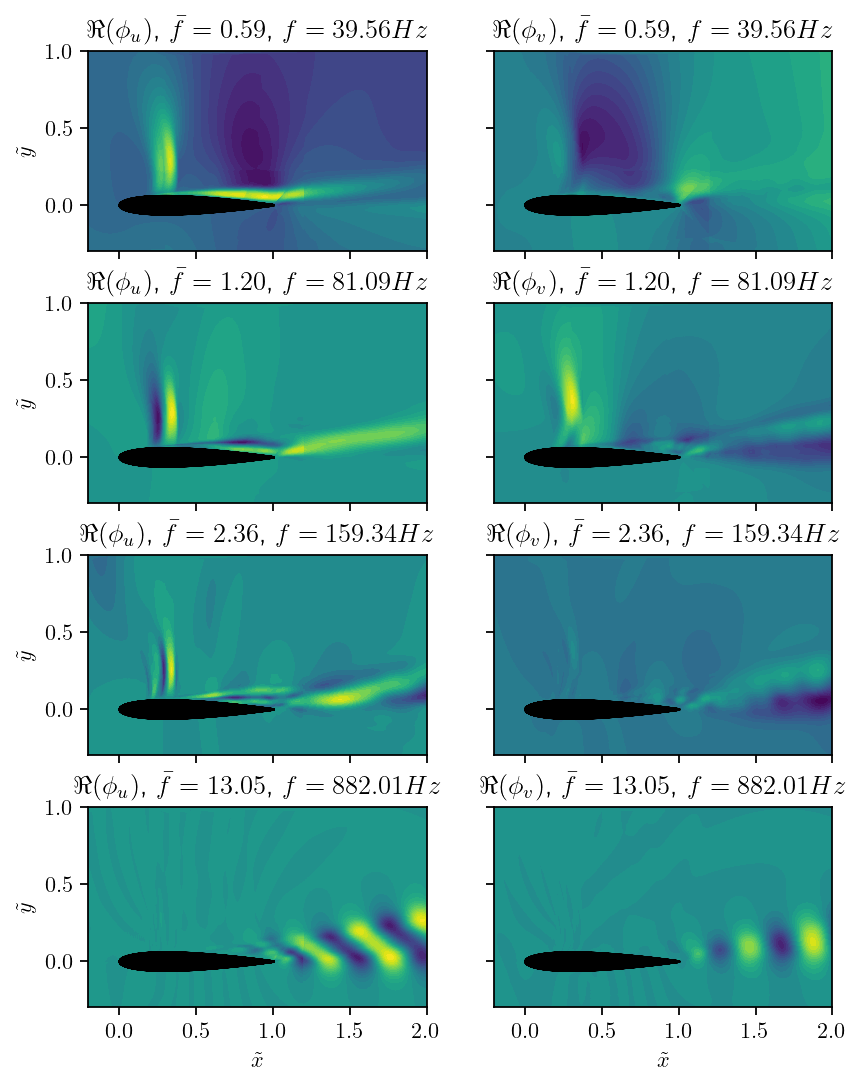

In [17]:
modes = [46, 41, 32, 10]
fig, axarr = plt.subplots(len(modes), 2, figsize=(6, 2*len(modes)), sharex=True, sharey=True)
every = 1

for i, mi in enumerate(modes):
    c_1 = axarr[i, 0].tricontourf(x3D[::every], y3D[::every], dmd3D.modes[:np3D:every, mi].real, levels=30)
    c_2 = axarr[i, 1].tricontourf(x3D[::every], y3D[::every], dmd3D.modes[np3D:2*np3D:every, mi].real, levels=30)
    axarr[i, 0].set_title(r"$\Re(\phi_u)$, $\bar{f}= " + "{:2.2f}$, $f={:2.2f}Hz$".format(normalize_frequency(freq3D[mi]), freq3D[mi]))
    axarr[i, 1].set_title(r"$\Re(\phi_v)$, $\bar{f}=" + "{:2.2f}$, $f={:2.2f}Hz$".format(normalize_frequency(freq3D[mi]), freq3D[mi]))
    axarr[i, 0].set_ylabel(r"$\tilde{y}$")
    for ax in axarr[i, :]:
        ax.set_aspect("equal")
        ax.set_xlim(-0.2, 2.0)
        ax.set_ylim(-0.3, 1.0)
        add_naca0012_patch(ax)

for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")
    
#cbar1 = fig.colorbar(c_1, ax=axarr[:, 0].ravel().tolist(), shrink=0.75, location="bottom", label=r"$\phi_i$", pad=0.05)
#cbar2 = fig.colorbar(c_2, ax=axarr[:, 1].ravel().tolist(), shrink=0.75, location="bottom", label=r"$\phi_i$", pad=0.05)
#cbar1.ax.locator_params(nbins=3)
#cbar2.ax.locator_params(nbins=3)

plt.savefig(output + "dmd_modes_3D.png", bbox_inches="tight")

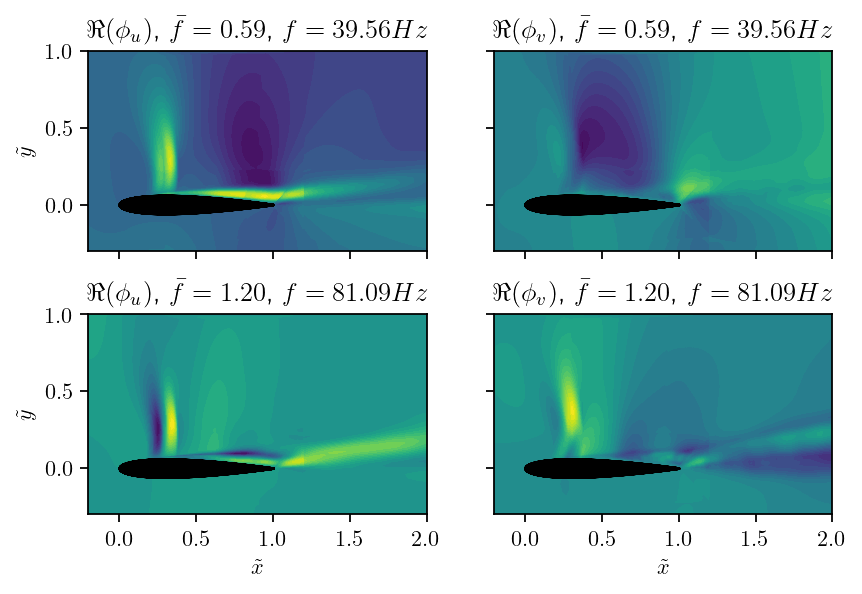

In [18]:
modes = [46, 41]
fig, axarr = plt.subplots(len(modes), 2, figsize=(6, 2*len(modes)), sharex=True, sharey=True)
every = 1

for i, mi in enumerate(modes):
    c_1 = axarr[i, 0].tricontourf(x3D[::every], y3D[::every], dmd3D.modes[:np3D:every, mi].real, levels=30)
    c_2 = axarr[i, 1].tricontourf(x3D[::every], y3D[::every], dmd3D.modes[np3D:2*np3D:every, mi].real, levels=30)
    axarr[i, 0].set_title(r"$\Re(\phi_u)$, $\bar{f}= " + "{:2.2f}$, $f={:2.2f}Hz$".format(normalize_frequency(freq3D[mi]), freq3D[mi]))
    axarr[i, 1].set_title(r"$\Re(\phi_v)$, $\bar{f}=" + "{:2.2f}$, $f={:2.2f}Hz$".format(normalize_frequency(freq3D[mi]), freq3D[mi]))
    axarr[i, 0].set_ylabel(r"$\tilde{y}$")
    for ax in axarr[i, :]:
        ax.set_aspect("equal")
        ax.set_xlim(-0.2, 2.0)
        ax.set_ylim(-0.3, 1.0)
        add_naca0012_patch(ax)

for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.savefig(output + "dmd_modes_3D_pres_1.png", bbox_inches="tight")

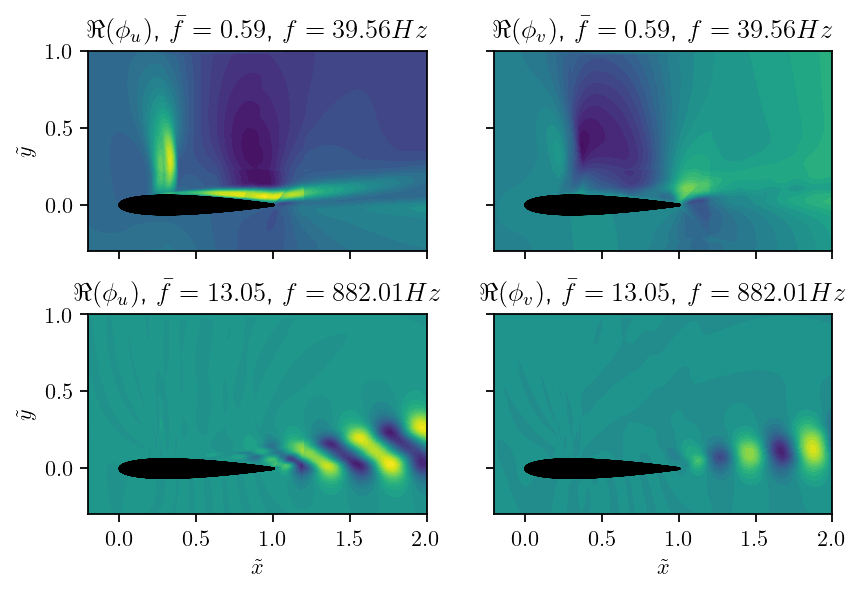

In [19]:
modes = [46, 10]
fig, axarr = plt.subplots(len(modes), 2, figsize=(6, 2*len(modes)), sharex=True, sharey=True)
every = 1

for i, mi in enumerate(modes):
    c_1 = axarr[i, 0].tricontourf(x3D[::every], y3D[::every], dmd3D.modes[:np3D:every, mi].real, levels=30)
    c_2 = axarr[i, 1].tricontourf(x3D[::every], y3D[::every], dmd3D.modes[np3D:2*np3D:every, mi].real, levels=30)
    axarr[i, 0].set_title(r"$\Re(\phi_u)$, $\bar{f}= " + "{:2.2f}$, $f={:2.2f}Hz$".format(normalize_frequency(freq3D[mi]), freq3D[mi]))
    axarr[i, 1].set_title(r"$\Re(\phi_v)$, $\bar{f}=" + "{:2.2f}$, $f={:2.2f}Hz$".format(normalize_frequency(freq3D[mi]), freq3D[mi]))
    axarr[i, 0].set_ylabel(r"$\tilde{y}$")
    for ax in axarr[i, :]:
        ax.set_aspect("equal")
        ax.set_xlim(-0.2, 2.0)
        ax.set_ylim(-0.3, 1.0)
        add_naca0012_patch(ax)

for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.savefig(output + "dmd_modes_3D_pres_2.png", bbox_inches="tight")

In [29]:
def animate_reconstruction(reconstruction, freq, interval):
    min_val, max_val = reconstruction.min(), reconstruction.max()
    fig, ax = plt.subplots(figsize=(4, 2), dpi=640)
    fig.set_size_inches(4.5, 3.0)
    def animate(i):
        print("\r", f"frame {i:03d}", end="")
        ax.clear()
        tri = ax.tricontourf(x3D, y3D, reconstruction[:, i], levels=30, cmap="jet", vmin=min_val, vmax=max_val)
        add_naca0012_patch(ax)
        ax.set_aspect("equal", 'box')
        ax.set_xlabel(r"$\tilde{x}$")
        ax.set_ylabel(r"$\tilde{y}$")
        ax.set_title(f"f={freq:2.2f}Hz")
        ax.set_xlim(-0.2, 2.0)
        ax.set_ylim(-0.3, 1.0)
    return FuncAnimation(fig, animate,  frames=reconstruction.shape[1], repeat=True, interval=interval)

In [33]:
writer = FFMpegWriter(fps=15, bitrate=1800)
for mode, f in zip([46, 41, 32, 10], [39.56, 81.09, 159.34, 882.01]):
    anim = animate_reconstruction(dmd3D.partial_reconstruction({mode})[:np3D, :400], f, 30)
    plt.close()
    anim.save(f"{output}dmd_3D_mode_{mode}_u.mp4", writer=writer)

 frame 399

In [36]:
for mode, f in zip([46, 41, 32, 10], [39.56, 81.09, 159.34, 882.01]):
    anim = animate_reconstruction(dmd3D.partial_reconstruction({mode})[np3D:2*np3D, :400], f, 30)
    plt.close()
    anim.save(f"{output}dmd_3D_mode_{mode}_v.mp4", writer=writer)

 frame 399

In [37]:
writer = FFMpegWriter(fps=30, bitrate=1800)
anim = animate_reconstruction(dmd3D.partial_reconstruction({46, 41})[:np3D, :400], f, 30)
plt.close()
anim.save(f"{output}dmd_3D_mode_46_41_u.mp4", writer=writer)

 frame 399

In [38]:
anim = animate_reconstruction(dmd3D.partial_reconstruction({46, 41})[np3D:2*np3D, :400], f, 30)
plt.close()
anim.save(f"{output}dmd_3D_mode_46_41_v.mp4", writer=writer)

 frame 399